In [1]:
#import __init__
import vsrl_utils as vu
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def draw_bbox(plt, ax, rois, fill=False, linewidth=2, edgecolor=[1.0, 0.0, 0.0], **kwargs):
    for i in range(rois.shape[0]):
        roi = rois[i,:].astype(np.int)
        ax.add_patch(plt.Rectangle((roi[0], roi[1]),
            roi[2] - roi[0], roi[3] - roi[1],
            fill=False, linewidth=linewidth, edgecolor=edgecolor, **kwargs))

def subplot(plt, Y, X, sz_y=10, sz_x=10):
    plt.rcParams['figure.figsize'] = (X*sz_x, Y*sz_y)
    fig, axes = plt.subplots(Y, X)
    return fig, axes

In [3]:
# Load COCO annotations for V-COCO images
coco = vu.load_coco()

# Load the VCOCO annotations for vcoco_train image set
vcoco_all = vu.load_vcoco('vcoco_train')
for x in vcoco_all:
    x = vu.attach_gt_boxes(x, coco)

loading annotations into memory...
Done (t=2.43s)
creating index...
index created!


In [8]:
# Action classes and roles in V-COCO
classes = [x['action_name'] for x in vcoco_all]
for i, x in enumerate(vcoco_all):
    print('{:>20s}'.format(x['action_name']), x['role_name'], len(vcoco_all))

                hold ['agent', 'obj'] 26
               stand ['agent'] 26
                 sit ['agent', 'instr'] 26
                ride ['agent', 'instr'] 26
                walk ['agent'] 26
                look ['agent', 'obj'] 26
                 hit ['agent', 'instr', 'obj'] 26
                 eat ['agent', 'obj', 'instr'] 26
                jump ['agent', 'instr'] 26
                 lay ['agent', 'instr'] 26
       talk_on_phone ['agent', 'instr'] 26
               carry ['agent', 'obj'] 26
               throw ['agent', 'obj'] 26
               catch ['agent', 'obj'] 26
                 cut ['agent', 'instr', 'obj'] 26
                 run ['agent'] 26
    work_on_computer ['agent', 'instr'] 26
                 ski ['agent', 'instr'] 26
                surf ['agent', 'instr'] 26
          skateboard ['agent', 'instr'] 26
               smile ['agent'] 26
               drink ['agent', 'instr'] 26
                kick ['agent', 'obj'] 26
               point ['agent', 'instr'

In [9]:
classes

['hold',
 'stand',
 'sit',
 'ride',
 'walk',
 'look',
 'hit',
 'eat',
 'jump',
 'lay',
 'talk_on_phone',
 'carry',
 'throw',
 'catch',
 'cut',
 'run',
 'work_on_computer',
 'ski',
 'surf',
 'skateboard',
 'smile',
 'drink',
 'kick',
 'point',
 'read',
 'snowboard']

In [129]:
# Visualize annotations for the some class
cls_id = classes.index('surf')
vcoco = vcoco_all[cls_id]

#vcoco.keys()
vcoco

{'image_id': array([[226162],
        [210751],
        [433398],
        ...,
        [314204],
        [234642],
        [419349]]),
 'ann_id': array([[ 183192],
        [ 183193],
        [ 183205],
        ...,
        [2207726],
        [2207790],
        [2207940]]),
 'role_object_id': array([[ 183192,       0],
        [ 183193,       0],
        [ 183205,       0],
        ...,
        [2207726,       0],
        [2207790,  648524],
        [2207940,       0]]),
 'label': array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]]),
 'action_name': 'surf',
 'role_name': ['agent', 'instr'],
 'include': [[], ['surfboard']],
 'bbox': array([[154.49,  71.25, 312.81, 395.57],
        [272.8 , 102.62, 489.02, 371.2 ],
        [291.24,  85.03, 639.64, 471.19],
        ...,
        [  3.16,   3.16, 339.75, 640.  ],
        [240.98, 131.59, 355.13, 304.92],
        [205.99, 167.01, 274.09, 398.81]]),
 'role_bbox': array([[154.49,  71.25, 312.81, ...,    nan

### vcoco data items of each action type
- **image_id**
    - ids of all images that contain this action type
- **ann_id**
    - annotation id of agent
- **role_object_id**
    - annotation ids of agent and objects
    - length varies according to different actions (role_name item as below)
    - ignored if 0
- **label**
    - 0 or 1 according to the followings, but exceptions may happen
    - 1: complete labelling in which both agent and objects are labeled
    - 0: incomplete labelling in which only agent is labeled
- **action_name**
    - name of action
- **role_name**
    - names of roles
- **include**
    - object names included (not complete)
- **bbox**
    - bbox of agent
- **role_bbox**
    - bboxes of agent and objects
    
### Recommended methods for image and annotations retrieving
- image retrieving
    - use **image_id** and **coco.loadImgs** to get json object of image
- annotations retrieving
    - use **role_object_id** to collect annotation ids of agent and objects
    - use **coco.loadAnns** and annotation ids to get json object of annotations
- bbox retrieving
    - use **role_box** to get bboxes of agent and objects

image id: 480437
file name: COCO_train2014_000000480437.jpg

annotation id: 474924
role_object_id: [474924 647375]
ann_id 474924, category_id 1: [{'supercategory': 'person', 'id': 1, 'name': 'person'}]
ann_id 647375, category_id 42: [{'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}]

bbox:  [[142.76  67.86 218.69 137.74]]
role_box:  [142.76  67.86 218.69 137.74 148.43 132.32 189.93 139.24]


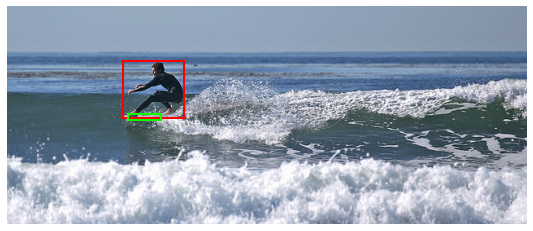

In [130]:
#np.random.seed(1)
positive_index = np.where(vcoco['label'] == 1)[0]
positive_index = np.random.permutation(positive_index)

# the demo here laods images from the COCO website, 
# you can alternatively use your own local folder of COCO images.
load_coco_image_from_web = False
if load_coco_image_from_web:
    base_coco_url = 'http://mscoco.org/images/'
    from PIL import Image
    from io import StringIO
    from urllib.request import urlopen
else:
    base_coco_dir = '/home/shuchen/data/github/iCAN/Data/v-coco/coco/images/train2014/'

cc = plt.get_cmap('hsv', lut=4)

for i in range(1):
    id = positive_index[i]

    # load image
    coco_image = coco.loadImgs(ids=[vcoco['image_id'][id][0]])[0]
    print(f'image id: {coco_image["id"]}')
    print(f'file name: {coco_image["file_name"]}')
    #print('coco_image: ', coco_image)
    print()
    
    # load annotations
    print(f'annotation id: {vcoco["ann_id"][id][0]}')
    role_object_id = vcoco['role_object_id'][id,:]
    print(f'role_object_id: {role_object_id}')
    for ann_id in role_object_id.tolist():
        if ann_id == 0:
            break
        anns = coco.loadAnns(ann_id)[0]
        cats_id = anns['category_id']
        cats = coco.loadCats(cats_id)
        print(f'ann_id {ann_id}, category_id {cats_id}: {cats}')
    print()
    
    if load_coco_image_from_web:
        coco_url = base_coco_url + str(coco_image['id'])
        file = StringIO(urlopen(coco_url).read())
        im = np.asarray(Image.open(file))
    else:
        file = base_coco_dir + coco_image['file_name']
        im = np.asarray(Image.open(file))
        
    sy = 4.; sx = float(im.shape[1])/float(im.shape[0])*sy;
    fig, ax = subplot(plt, 1, 1, sy, sx); ax.set_axis_off(); 
    ax.imshow(im);
    
    # draw bounding box for agent
    draw_bbox(plt, ax, vcoco['bbox'][[id],:], edgecolor=cc(0)[:3])
    print('bbox: ', vcoco['bbox'][[id],:])
    
    # draw bounding box for roles
    role_bbox = vcoco['role_bbox'][id,:]*1.
    print('role_box: ', role_bbox)
    role_bbox = role_bbox.reshape((-1,4))
    for j in range(1, len(vcoco['role_name'])):
        if not np.isnan(role_bbox[j,0]):
            draw_bbox(plt, ax, role_bbox[[j],:], edgecolor=cc(j)[:3])

### 